# Exploratory NLP on chat messages in pilot data

To do:
-- try different tokenizer to deal with punctuation?
-- bag of tower model (tower pairs: group L/C and C/L)
    for each pair, compare first and last occurance of a specific BOT
    interested in words that drop out and words that increase in frequency
-- fix dictionary to be union not intersection
-- TFIDF for tower specific 
    what are the specific words we use to describe tower pairs
-- condition on rep 1, use same langauge for all three items, do subjects disambiguate by the later trials

-- compare probability of words for L-pi and L-C in early and late stages (factor out the "L") 

[X] try tf-idf with LC as doc 1 and LP,CP combined as doc 2 in final rep 

## Import packages

In [1]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
from collections import Counter
from num2words import num2words
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from gensim import matutils, models
import matplotlib.pyplot as plt

import nltk
import os
import string
import numpy as np
import copy
import pandas as pd
pd.set_option('display.max_colwidth', 1000)
import pickle
import re
import math


stemmer = SnowballStemmer("english")

## Import data frames (generated in DF_generator script from mongoDB)

In [2]:
df_chat = pd.read_csv('df_chat.csv')
print(df_chat.shape)
print("Dyads:",len(df_chat.gameid.unique()))

(3066, 21)
Dyads: 71


### Check exclusion criteria

In [3]:
df_trial = pd.read_csv('df_trial.csv')
df75 = pd.DataFrame(df_trial.groupby(['gameid', 'trialNum'])['trialScore'].sum()>75).groupby(['gameid']).sum()
df75['trials'] = df75['trialScore']

#delete rows that aren't greater than 75% in 9 trials
df75 = df75[df75['trials']>=9]

print("Total dyads achieving 75% Accuracy on 75% of trials:",len(df75))

Total dyads achieving 75% Accuracy on 75% of trials: 48


### Remove dyads that did not pass exclusion criteria

In [4]:
keep_id = df75.index.tolist()
keep_id
df = df_chat[df_chat['gameid'].isin(keep_id)]
print(df.shape)
print("Passed Dyads:",len(df.gameid.unique()))

(2223, 21)
Passed Dyads: 48


In [5]:
df = df[['repNum','content','trialNum', 'leftTarget', 'rightTarget']]
df = df[df.trialNum != 'practice']
df = df[df.repNum != 'practice']
df['C'] = (df['leftTarget'] + df['rightTarget']).apply(lambda x: 1 if 'C' in x   else 0)
df['L'] = (df['leftTarget'] + df['rightTarget']).apply(lambda x: 1 if 'L' in x   else 0)
df['P'] = (df['leftTarget'] + df['rightTarget']).apply(lambda x: 1 if 'Pi' in x   else 0)
df = df.drop(['leftTarget', 'rightTarget'],axis = 1)
df.head(2)


,repNum,content,trialNum,C,L,P
2,0,put a blue block three from the left~~~,0,1,0,1
3,0,place a red block on top of the left side of the blue block and then another red on top of that red,0,1,0,1


## Create Bag of Words for each repNum by concatenating content
create df with column for repnum and column for entire string grouped by repnum

In [6]:
# df['BOW'] = df[['repNum','C','L','Pi','content']].groupby(['repNum','C','L','Pi'])['content'].transform(lambda x: ' '.join(x))
# df = df[['repNum','C','L','Pi','BOW']]
df = df.groupby(['repNum','C','L','P'])['content'].apply(lambda x: ' '.join(x)).reset_index()

print(df.shape)
df.head(2)

(12, 5)


,repNum,C,L,P,content
0,0,0,1,1,"Do the same L shape on the left side as last time with 2x blue and 2x red two spots from the left place a red block two from the right, then a gap of two and another red block then two blues connect just place the other blue on on top of one of the red blocks Place 2 blue blocks, each directly next to the left red line~~~ Place a red block on top of the leftmost blue square~~~ Place another on top of the red (makes an ""L"") Place red block two spaces from the right line similar to last trial Do the same on the other side with a red block\n\n Place a blue on the rightmost red block so its end is facing to the left Place a blue on the other red block so the two blue ends are touching now sq 2 H blk sq 4 H blk sq 2 V blk over H blk V blk over V blk sq 8 V blk \nThis figure is like first picture right figure sq 8 V blk sq 8 H blk over V blk sq 11 V blk sq 11 H blk over V place reverse L place it doen place down place again L shape on the left side, just like on the last trial~~~ Arch on..."
1,0,1,0,1,"put a blue block three from the left~~~ place a red block on top of the left side of the blue block and then another red on top of that red Now place a blue block on top of that that lines up with the bottom blue block remove that last blue block, place it on top of the red blocks place a red block on the second grid from the right of the screen\n now place another red block three more space to the left of that one place two blue blocks next to each other connecting on top of the two red blocks\n Place blue in middle of left tick~~~ Stack 2 reds on top of the left side of the blue block Place blue block on top of the red you just placed so it looks like an elongated ""C~~~""\n Place red block two spaces from the right red tick~~~ This means there's 1 empty space to the tick Count two spaces from the red tick to the right and place the red block in that 2nd space~~~ Do the same, place a red counting two blocks but this time to the left of the tick~~~ Place a blue block on top of the..."


In [7]:
df_chat.isnull().sum()

Unnamed: 0                      0
_id                             0
iterationName                   0
gameid                          0
time                            0
assignmentId                    0
leftTarget                      0
rightTarget                     0
trialNum                      112
turnNum                         0
repNum                          0
content                         0
timeElapsedInTurn               0
timeElapsedInTrial              0
eventType                       0
individualPracticeAttempts    938
turnStartTime                 980
trialStartTime                980
practice                      980
word_count                      0
char_count                      0
dtype: int64

### Remove stopwords

In [46]:
from nltk.corpus import stopwords
stop = stopwords.words('english')
df['BOW_clean'] = df['content'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

In [47]:
import num2words
from num2words import num2words
def num_2_words(sentence):
    out = ""
    for word in sentence.split():
        try:
            o = num2words(word)
        except:
            o = word
        out = out+" "+ o
    return out

In [48]:
df['BOW_clean'] = df['BOW_clean'].apply(lambda x: num_2_words(x))

In [49]:
df['BOW_clean'] = df['BOW_clean'].str.lower()
df['BOW_clean'] = df['BOW_clean'].str.replace(r'~', '')
df['BOW_clean'] = df['BOW_clean'].str.replace(r'\(', '')
df['BOW_clean'] = df['BOW_clean'].str.replace(r'\)', '')
df['BOW_clean'] = df['BOW_clean'].str.replace(r'\,', '')
df['BOW_clean'] = df['BOW_clean'].str.replace(r"\'", '')
df['BOW_clean'] = df['BOW_clean'].str.replace(r"\:", '')
df.head(2)

,repNum,C,L,P,content,BOW_clean,BOW_lemmatized
0,0,0,1,1,"Do the same L shape on the left side as last time with 2x blue and 2x red two spots from the left place a red block two from the right, then a gap of two and another red block then two blues connect just place the other blue on on top of one of the red blocks Place 2 blue blocks, each directly next to the left red line~~~ Place a red block on top of the leftmost blue square~~~ Place another on top of the red (makes an ""L"") Place red block two spaces from the right line similar to last trial Do the same on the other side with a red block\n\n Place a blue on the rightmost red block so its end is facing to the left Place a blue on the other red block so the two blue ends are touching now sq 2 H blk sq 4 H blk sq 2 V blk over H blk V blk over V blk sq 8 V blk \nThis figure is like first picture right figure sq 8 V blk sq 8 H blk over V blk sq 11 V blk sq 11 H blk over V place reverse L place it doen place down place again L shape on the left side, just like on the last trial~~~ Arch on...","do l shape left side last time 2x blue 2x red two spots left place red block two right gap two another red block two blues connect place blue top one red blocks place two blue blocks directly next left red line place red block top leftmost blue square place another top red makes ""l"" place red block two spaces right line similar last trial do side red block place blue rightmost red block end facing left place blue red block two blue ends touching sq two h blk sq four h blk sq two v blk h blk v blk v blk sq eight v blk this figure like first picture right figure sq eight v blk sq eight h blk v blk sq eleven v blk sq eleven h blk v place reverse l place doen place place l shape left side like last trial arch right xxxx x--x x--x skip one block away red line put vertical block there mirror side place blue one right flat place blue next previous one red top first place another red top previous red place one red one left far right place another red two left first red connect two blues p...","[do, l, shape, left, side, last, time, 2x, blue, 2x, red, two, spot, left, place, red, block, two, right, gap, two, another, red, block, two, blue, connect, place, blue, top, one, red, block, place, 2, blue, block, directly, next, left, red, line, place, red, block, top, leftmost, blue, square, place, another, top, red, make, l, place, red, block, two, space, right, line, similar, last, trial, do, side, red, block, place, blue, rightmost, red, block, end, facing, left, place, blue, red, block, two, blue, end, touching, sq, 2, h, blk, sq, 4, h, blk, sq, 2, v, blk, h, blk, v, ...]"
1,0,1,0,1,"put a blue block three from the left~~~ place a red block on top of the left side of the blue block and then another red on top of that red Now place a blue block on top of that that lines up with the bottom blue block remove that last blue block, place it on top of the red blocks place a red block on the second grid from the right of the screen\n now place another red block three more space to the left of that one place two blue blocks next to each other connecting on top of the two red blocks\n Place blue in middle of left tick~~~ Stack 2 reds on top of the left side of the blue block Place blue block on top of the red you just placed so it looks like an elongated ""C~~~""\n Place red block two spaces from the right red tick~~~ This means there's 1 empty space to the tick Count two spaces from the red tick to the right and place the red block in that 2nd space~~~ Do the same, place a red counting two blocks but this time to the left of the tick~~~ Place a blue block on top of the...","put blue block three left place red block top left side blue block another red top red now place blue block top lines bottom blue block remove last blue block place top red blocks place red block second grid right screen place another red block three space left one place two blue blocks next connecting top two red blocks place blue m

In [50]:
import nltk
from nltk.tokenize import RegexpTokenizer
tokenizer = RegexpTokenizer(r'\w+')
w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = nltk.stem.WordNetLemmatizer()

def lemmatize_text(text):
    return [lemmatizer.lemmatize(w) for w in tokenizer.tokenize(text)]
df['BOW_lemmatized'] = df['BOW_clean'].apply(lemmatize_text)
df.head(1)

,repNum,C,L,P,content,BOW_clean,BOW_lemmatized
0,0,0,1,1,"Do the same L shape on the left side as last time with 2x blue and 2x red two spots from the left place a red block two from the right, then a gap of two and another red block then two blues connect just place the other blue on on top of one of the red blocks Place 2 blue blocks, each directly next to the left red line~~~ Place a red block on top of the leftmost blue square~~~ Place another on top of the red (makes an ""L"") Place red block two spaces from the right line similar to last trial Do the same on the other side with a red block\n\n Place a blue on the rightmost red block so its end is facing to the left Place a blue on the other red block so the two blue ends are touching now sq 2 H blk sq 4 H blk sq 2 V blk over H blk V blk over V blk sq 8 V blk \nThis figure is like first picture right figure sq 8 V blk sq 8 H blk over V blk sq 11 V blk sq 11 H blk over V place reverse L place it doen place down place again L shape on the left side, just like on the last trial~~~ Arch on...","do l shape left side last time 2x blue 2x red two spots left place red block two right gap two another red block two blues connect place blue top one red blocks place two blue blocks directly next left red line place red block top leftmost blue square place another top red makes ""l"" place red block two spaces right line similar last trial do side red block place blue rightmost red block end facing left place blue red block two blue ends touching sq two h blk sq four h blk sq two v blk h blk v blk v blk sq eight v blk this figure like first picture right figure sq eight v blk sq eight h blk v blk sq eleven v blk sq eleven h blk v place reverse l place doen place place l shape left side like last trial arch right xxxx x--x x--x skip one block away red line put vertical block there mirror side place blue one right flat place blue next previous one red top first place another red top previous red place one red one left far right place another red two left first red connect two blues p...","[do, l, shape, left, side, last, time, 2x, blue, 2x, red, two, spot, left, place, red, block, two, right, gap, two, another, red, block, two, blue, connect, place, blue, top, one, red, block, place, two, blue, block, directly, next, left, red, line, place, red, block, top, leftmost, blue, square, place, another, top, red, make, l, place, red, block, two, space, right, line, similar, last, trial, do, side, red, block, place, blue, rightmost, red, block, end, facing, left, place, blue, red, block, two, blue, end, touching, sq, two, h, blk, sq, four, h, blk, sq, two, v, blk, h, blk, v, ...]"


### Build a matrix of each word in the corpus and its TF-IDF for that comment

In [51]:
from sklearn.feature_extraction.text import TfidfVectorizer
corpus = df['BOW_clean']
vectorizer = TfidfVectorizer(sublinear_tf = True)
vectors = vectorizer.fit_transform(corpus)
feature_names = vectorizer.get_feature_names()
dense = vectors.todense()
denselist = dense.tolist()
df_vectors = pd.DataFrame(denselist, columns=feature_names)

### Select the top 5 words (TF-IDF) for each comment
##### Intuitively, this roughly corresponds to what this person is talking about relatively more than any other person

In [52]:
Tops = pd.DataFrame(df_vectors.apply(lambda x:list(df_vectors.columns[np.array(x).argsort()[::-1][:15]]), axis=1).to_list())

Tops

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,red,blue,block,two,left,right,column,wall,one,place,fully,rows,little,top,blocks
1,away,block,red,blue,left,bar,wall,top,right,place,two,one,column,actually,ad
2,red,blue,block,left,column,wall,top,two,right,start,bar,meant,finish,place,one
3,left,red,wall,blue,right,two,line,column,one,again,side,top,block,place,eight
4,red,blue,wall,left,right,two,top,block,line,place,one,side,made,blk,mirroring
5,from,blue,red,left,right,two,top,block,column,fromright,side,line,one,eight,ooxooooxoooo
6,left,red,right,blue,two,one,line,side,2nd,eight,place,top,shape,block,well
7,red,left,blue,right,two,one,line,top,side,three,3rd,block,shape,upside,eight
8,blue,left,right,red,two,one,line,top,side,call,oxooooooxooo,results,im,place,four
9,left,right,red,blue,two,line,one,eight,side,ovr,five,shape,upside,rw,lw


## Okay, that was a dud, let's just plot histograms of word frequency for each repNum

In [55]:
df_grouped = df.groupby(['repNum'])['BOW_clean'].apply(lambda x: ' '.join(x)).reset_index()

print(df_grouped.shape)

(4, 2)


In [56]:
df_grouped = df.groupby('repNum').agg({'BOW_lemmatized': 'sum'})

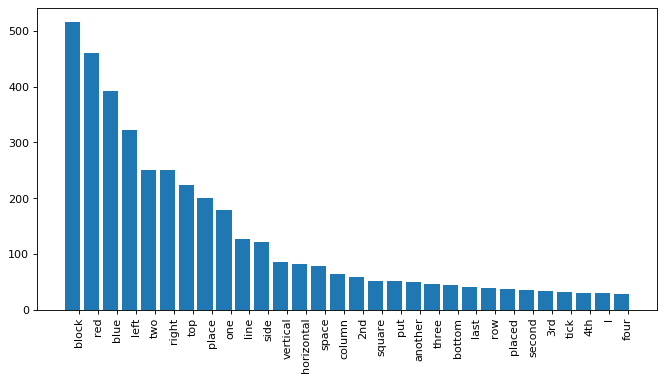

In [57]:
from matplotlib.pyplot import figure
figure(num=None, figsize=(10, 5), dpi=80, facecolor='w', edgecolor='k')

from collections import Counter
x_limit = 30

word_list = df_grouped['BOW_lemmatized'].iloc[0]

counts = Counter(word_list)

labels, values = zip(*counts.items())

# sort your values in descending order
indSort = np.argsort(values)[::-1]

# rearrange your data
labels = np.array(labels)[indSort][:x_limit]
values = np.array(values)[indSort][:x_limit]

indexes = np.arange(len(labels))

bar_width = 0.35

plt.bar(indexes, values)

# add labels
plt.xticks(indexes + bar_width, labels,  rotation='vertical')
plt.show()

In [58]:
total = sum(counts.values())

rep_0 = {k: v / total for k, v in counts.items()}

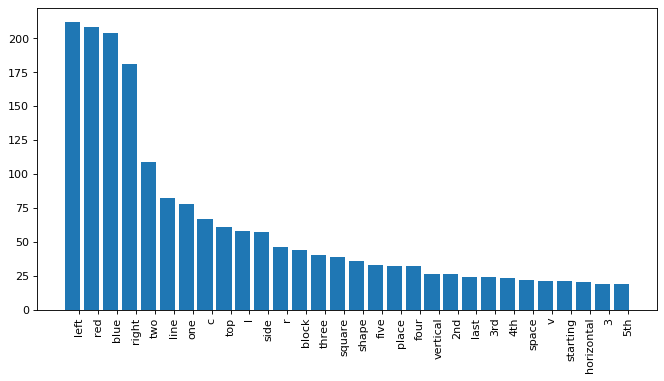

In [59]:
figure(num=None, figsize=(10, 5), dpi=80, facecolor='w', edgecolor='k')
x_limit = 30

word_list = df_grouped['BOW_lemmatized'].iloc[3]

counts = Counter(word_list)

labels, values = zip(*counts.items())

# sort your values in descending order
indSort = np.argsort(values)[::-1]

# rearrange your data
labels = np.array(labels)[indSort][:x_limit]
values = np.array(values)[indSort][:x_limit]

indexes = np.arange(len(labels))

bar_width = 0.35

plt.bar(indexes, values)

# add labels
plt.xticks(indexes + bar_width, labels,  rotation='vertical')
plt.show()

In [60]:
total = sum(counts.values())

rep_3 = {k: v / total for k, v in counts.items()}

In [61]:
d_diff = {key: rep_3[key] - rep_0.get(key, 0) for key in rep_3}

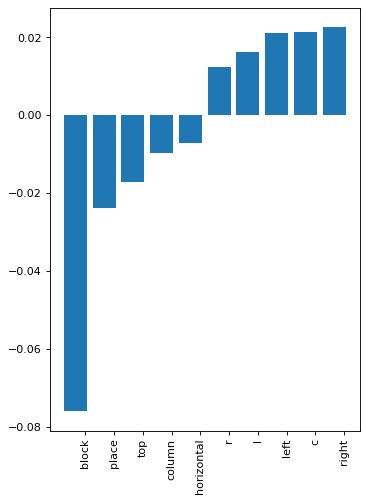

In [64]:
figure(num=None, figsize=(5, 7), dpi=80, facecolor='w', edgecolor='k')
x_limit = 5

labels, values = zip(*d_diff.items())

# sort your values in descending order
indSort_high = np.argsort(values)[::-1]
indSort_low = np.argsort(values)

# rearrange your data
#labels = np.array(labels)[indSort_high][:x_limit][::-1]
labels = np.concatenate([np.array(labels)[indSort_low][:x_limit],np.array(labels)[indSort_high][:x_limit][::-1]])
#values = np.array(values)[indSort_high][:x_limit][::-1]
values = np.concatenate([np.array(values)[indSort_low][:x_limit], np.array(values)[indSort_high][:x_limit][::-1]])

indexes = np.arange(len(labels))

bar_width = 0.35

plt.bar(indexes, values)

# add labels
plt.xticks(indexes + bar_width, labels,  rotation='vertical')
plt.show()

## Build Towerset specific BOW separated by first and last rep

In [229]:
CL_0 = df.loc[(df['C'] == 1) & (df['L'] == 1), 'BOW_clean'].iloc[0].split()
CL_3 = df.loc[(df['C'] == 1) & (df['L'] == 1), 'BOW_clean'].iloc[3].split()
LP_0 = df.loc[(df['L'] == 1) & (df['P'] == 1), 'BOW_clean'].iloc[0].split()
LP_3 = df.loc[(df['L'] == 1) & (df['P'] == 1), 'BOW_clean'].iloc[3].split()
CP_0 = df.loc[(df['C'] == 1) & (df['P'] == 1), 'BOW_clean'].iloc[0].split()
CP_3 = df.loc[(df['C'] == 1) & (df['P'] == 1), 'BOW_clean'].iloc[3].split()


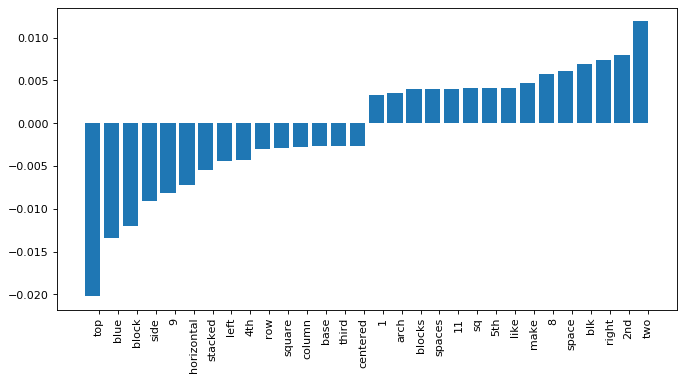

In [233]:
set1, set2 = CL_0, LP_0

#Get word counts for first set
counts = Counter(set1)
total = sum(counts.values())
d1 = {k: v / total for k, v in counts.items()}
#Get word counts for CL3
counts = Counter(set2)
total = sum(counts.values())
d2 = {k: v / total for k, v in counts.items()}
labels, values = zip(*counts.items())

#Get difference in count dicts
d_diff = {key: d2[key] - d1.get(key, 0) for key in d2}


#Plot difference
figure(num=None, figsize=(10, 5), dpi=80, facecolor='w', edgecolor='k')
x_limit = 15

labels, values = zip(*d_diff.items())

# sort your values in descending order
indSort_high = np.argsort(values)[::-1]
indSort_low = np.argsort(values)

# rearrange the data
#labels = np.array(labels)[indSort_high][:x_limit][::-1]
labels = np.concatenate([np.array(labels)[indSort_low][:x_limit],np.array(labels)[indSort_high][:x_limit][::-1]])
#values = np.array(values)[indSort_high][:x_limit][::-1]
values = np.concatenate([np.array(values)[indSort_low][:x_limit], np.array(values)[indSort_high][:x_limit][::-1]])

indexes = np.arange(len(labels))
bar_width = 0.35
plt.bar(indexes, values)

# add labels
plt.xticks(indexes + bar_width, labels,  rotation='vertical')
plt.show()

## WORD CLOUD!
perhaps pointless, but definitely fun!

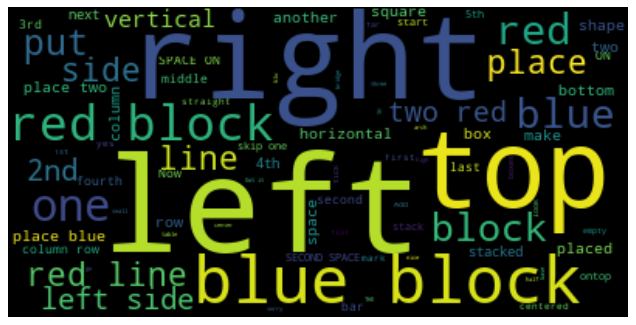

In [159]:
from wordcloud import WordCloud
figure(num=None, figsize=(10, 10), dpi=80, facecolor='w', edgecolor='k')
wordcloud = WordCloud().generate(df['BOW_clean'].iloc[1])

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()


## Try TF-IDF with tower specific docs

In [214]:
CP_3 = df.loc[(df['C'] == 1) & (df['P'] == 1), 'BOW_clean'].iloc[3]
CL_3 = df.loc[(df['C'] == 1) & (df['L'] == 1), 'BOW_clean'].iloc[3]
LP_3 = df.loc[(df['L'] == 1) & (df['P'] == 1), 'BOW_clean'].iloc[3]

doc1 = "hello this this this this this two five ten"
doc2 = "Other thing this this this this this two hello else"

vectorizer = TfidfVectorizer(sublinear_tf = True)
vectors = vectorizer.fit_transform([doc1,doc2])
feature_names = vectorizer.get_feature_names()
dense = vectors.todense()
denselist = dense.tolist()
df_vectors = pd.DataFrame(denselist, columns=feature_names)

Tops = pd.DataFrame(df_vectors.apply(lambda x:list(df_vectors.columns[np.array(x).argsort()[::-1][:15]]), axis=1).to_list())

Tops

,0,1,2,3,4,5,6,7
0,this,ten,five,two,hello,thing,other,else
1,this,thing,other,else,two,hello,ten,five


In [212]:
len(doc1)

839